In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyhacores.utils import *
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

In [3]:
from pyhacores.cordic import ToPolar, Angle, Abs
import inspect
print(inspect.getdoc(ToPolar))
print(inspect.getdoc(Angle))
print(inspect.getdoc(Abs))

Converts IQ to polar form, returning 'abs' and 'angle'. Angle is in [-1 to 1] range i.e. divided by np.pi.
Equal to Numpy.angle()/pi
Equal to Numpy.abs()


# Applications

## `ToPolar`: Convert IQ to polar form i.e. 'abs' and 'angle'

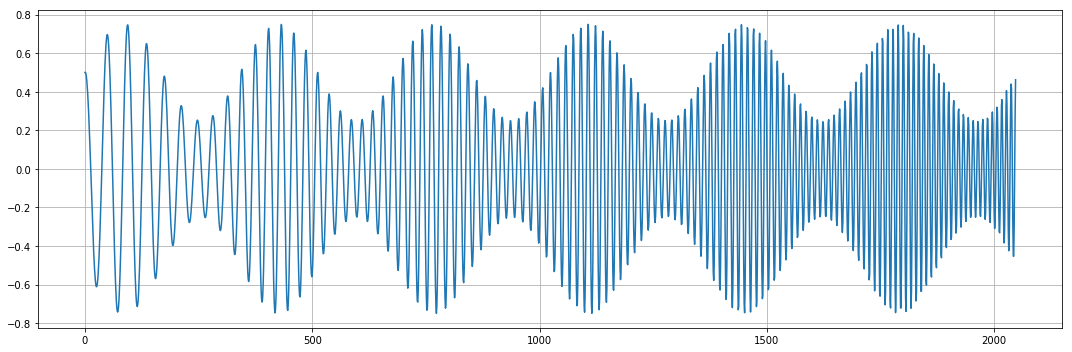

In [4]:
""" Amplitude modulated chirp signal """
from scipy.signal import chirp, hilbert
duration = 2.0
fs = 1024
samples = int(fs * duration)
t = np.arange(samples) / fs
signal = chirp(t, 20.0, t[-1], 100.0)
signal *= (1.0 + 0.5 * np.sin(2.0 * np.pi * 3.0 * t))
input_signal = hilbert(signal) * 0.5
# ref_abs = np.abs(analytic_signal)
# ref_instantaneous_phase = np.angle(analytic_signal)
plt.plot(input_signal)
show_plot()

In [5]:
dut_topolar = ToPolar()
sims = simulate(dut_topolar, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 2063/2063 [00:03<00:00, 647.37it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [6]:
assert sims_close(sims, rtol=1e-2, atol=1e-4)

INFO:sim:sims_close(rtol=0.01, atol=0.0001)
INFO:sim:Using "MODEL" as golden output
INFO:sim:MODEL OK!
INFO:sim:PYHA OK!


In [7]:
print(f"SNR: {snr(sims['MODEL'], sims['PYHA'])} dB")

SNR: 86.67413906955544 dB


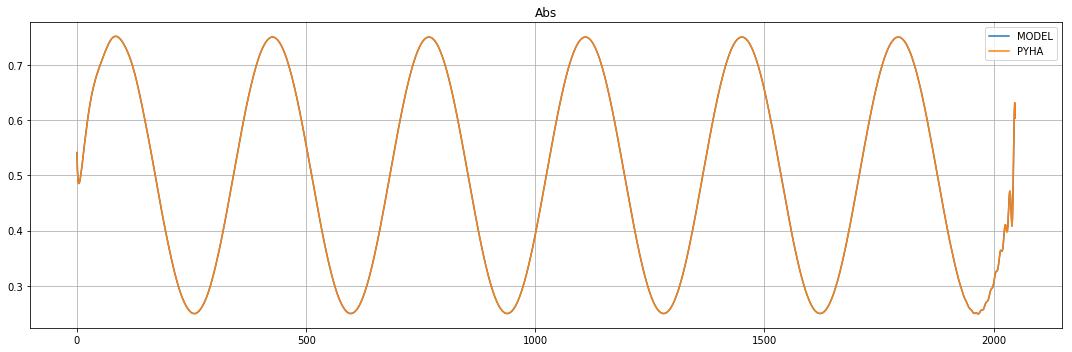

In [8]:
plt.title('Abs')
for key, value in sims.items():
    abbs, phase = value
    plt.plot(abbs, label=key)
show_plot()

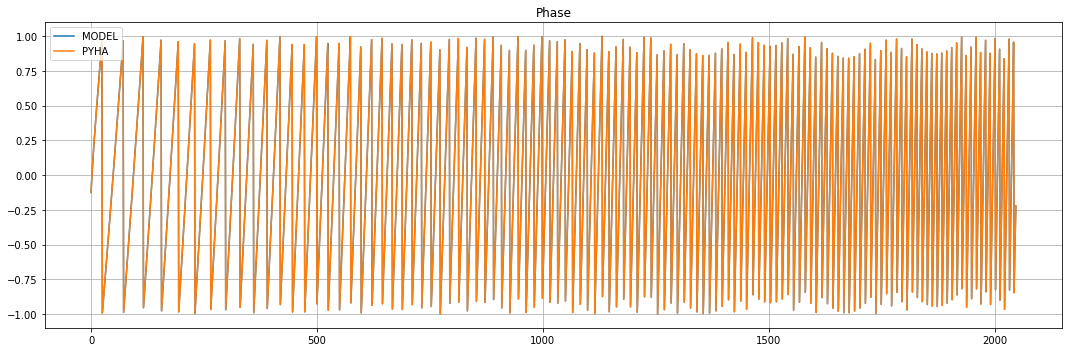

In [9]:
plt.title('Phase')
for key, value in sims.items():
    abbs, phase = value
    plt.plot(phase, label=key)
show_plot()

## `Angle`: Equivalent for `Numpy.angle()/pi`


In [10]:
dut_angle = Angle()
sims = simulate(dut_angle, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 2063/2063 [00:03<00:00, 640.26it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [11]:
assert sims_close(sims, rtol=1e-2, atol=1e-4)

INFO:sim:sims_close(rtol=0.01, atol=0.0001)
INFO:sim:Using "MODEL" as golden output
INFO:sim:MODEL OK!
INFO:sim:PYHA OK!


In [12]:
print(f"SNR: {snr(sims['MODEL'], sims['PYHA'])} dB")

SNR: 82.15416627987474 dB


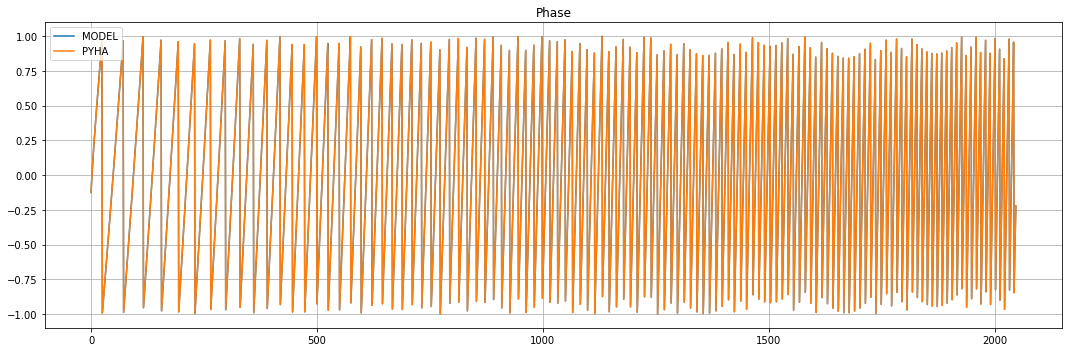

In [13]:
plt.title('Phase')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

## `Abs`: Equivalent for `Numpy.abs()`

In [14]:
dut_abs = Abs()
sims = simulate(dut_abs, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 2063/2063 [00:03<00:00, 633.44it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [15]:
assert sims_close(sims, rtol=1e-2, atol=1e-4)

INFO:sim:sims_close(rtol=0.01, atol=0.0001)
INFO:sim:Using "MODEL" as golden output
INFO:sim:MODEL OK!
INFO:sim:PYHA OK!


In [16]:
print(f"SNR: {snr(sims['MODEL'], sims['PYHA'])} dB")

SNR: 96.63827591248864 dB


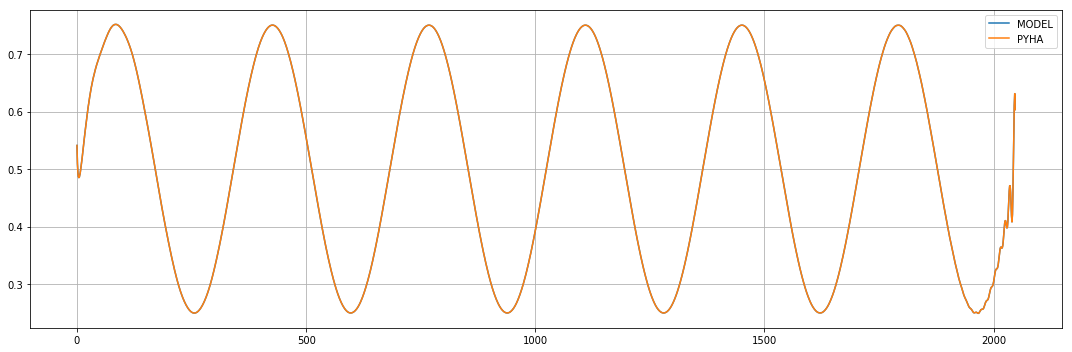

In [17]:
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [18]:
print(f'Minimum number representabe: {2**-17}')

Minimum number representabe: 7.62939453125e-06


# Synthesis

## ToPolar

In [19]:
# NBVAL_IGNORE_OUTPUT
c = convertToVHDL(dut_topolar, '/tmp/pyha_output')
_ = c.make_quartus_netlist()

INFO:conversion:Creating top.vhd ...
INFO:conversion:Cordic to VHDL ...
INFO:conversion:ToPolar to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Thu Aug  2 15:32:11 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 1,179
INFO:sim:    Total combinational functions : 1,163
INFO:sim:    Dedicated logic registers : 756
INFO:sim:Total registers : 756
INFO:sim:Total pins : 74
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 0
INFO:sim:Embedded Multiplier 9-bit elements : 4
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.


In [20]:
print(f'Logic elements: {c.last_logic_elements}')
print(f'Memory: {c.last_memory_bits}')
print(f'Multipler (18bit): {c.last_multiplier//2}')

Logic elements: 1179
Memory: 0
Multipler (18bit): 2


## Angle

In [21]:
# NBVAL_IGNORE_OUTPUT
c = convertToVHDL(dut_angle, '/tmp/pyha_output')
_ = c.make_quartus_netlist()

INFO:conversion:Creating top.vhd ...
INFO:conversion:Cordic to VHDL ...
INFO:conversion:ToPolar to VHDL ...
INFO:conversion:Angle to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Thu Aug  2 15:32:21 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 1,100
INFO:sim:    Total combinational functions : 1,084
INFO:sim:    Dedicated logic registers : 683
INFO:sim:Total registers : 683
INFO:sim:Total pins : 56
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 0
INFO:sim:Embedded Multiplier 9-bit elements : 0
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.


In [22]:
print(f'Logic elements: {c.last_logic_elements}')
print(f'Memory: {c.last_memory_bits}')
print(f'Multipler (18bit): {c.last_multiplier//2}')

Logic elements: 1100
Memory: 0
Multipler (18bit): 0


## Abs

In [23]:
# NBVAL_IGNORE_OUTPUT
c = convertToVHDL(dut_abs, '/tmp/pyha_output')
_ = c.make_quartus_netlist()

INFO:conversion:Creating top.vhd ...
INFO:conversion:Cordic to VHDL ...
INFO:conversion:ToPolar to VHDL ...
INFO:conversion:Abs to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Thu Aug  2 15:32:31 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 910
INFO:sim:    Total combinational functions : 910
INFO:sim:    Dedicated logic registers : 519
INFO:sim:Total registers : 519
INFO:sim:Total pins : 56
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 0
INFO:sim:Embedded Multiplier 9-bit elements : 4
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.


In [24]:
print(f'Logic elements: {c.last_logic_elements}')
print(f'Memory: {c.last_memory_bits}')
print(f'Multipler (18bit): {c.last_multiplier//2}')

Logic elements: 910
Memory: 0
Multipler (18bit): 2
